In [2]:
from __future__ import division

import pandas as pd
from pandas import ExcelWriter
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
#import html2text
from datetime import date
import random
import os

#Packages for pulling text data 
from urllib.request import urlopen  # the lib that handles the url stuff
from bs4 import BeautifulSoup
import pandas.io.data as web
from pandas.tseries.offsets import BDay

#Packages for text data processing
import nltk, re, pprint
#nltk.download()
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

'''
#Packages for statistical learning 
from sklearn.preprocessing import normalize as Normal
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn import linear_model
'''

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

import imp

import Text_Analytics as TA

C:\Users\ziyi\Anaconda3\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [3]:
#from imp import reload 
imp.reload(TA)

<module 'Text_Analytics' from 'C:\\Users\\ziyi\\Documents\\Inde project\\Independent Study Anseri-20170120T004329Z\\Independent Study Anseri\\Code repo\\Text_Analytics.py'>

In [9]:
#Setup working directory 
os.chdir("C:/Users/ziyi/Documents/Inde project/Independent Study Anseri-20170120T004329Z/Independent Study Anseri/8K data/MID_Sectors/Input")

#Import Data
df_return_raw=pd.read_csv('Price_ts_Info.csv',parse_dates=True,index_col=0)
df_text_raw=pd.read_csv('Information Technology_ts_events.csv',parse_dates=True,index_col=0)

In [10]:
df_text_raw=df_text_raw.loc[df_return_raw.index]

In [11]:
df_text_raw.to_csv("Information Technology_ts_events.csv",index_col=0)

## Univariate Analysis - 01/04/2016 - 12/30/2016

start="2015-12-31"
end="2016-12-30"

In [12]:
df_text=df_text_raw

In [13]:
df_return=df_return_raw

In [14]:
df_text_sum=df_text.sum()
keep_events=df_text_sum[df_text_sum!=0].index

In [15]:
#Keep only events with non-zero records 
df_text=df_text[keep_events]

In [16]:
df_text.columns

Index(['ITEM 1.01', 'ITEM 1.02', 'ITEM 2.01', 'ITEM 2.02', 'ITEM 2.03',
       'ITEM 2.05', 'ITEM 2.06', 'ITEM 3.01', 'ITEM 3.02', 'ITEM 3.03',
       'ITEM 4.01', 'ITEM 4.02', 'ITEM 5.01', 'ITEM 5.02', 'ITEM 5.03',
       'ITEM 5.04', 'ITEM 5.05', 'ITEM 5.07', 'ITEM 7.01', 'ITEM 8.01',
       'ITEM 9.01'],
      dtype='object')

C:\Users\ziyi\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


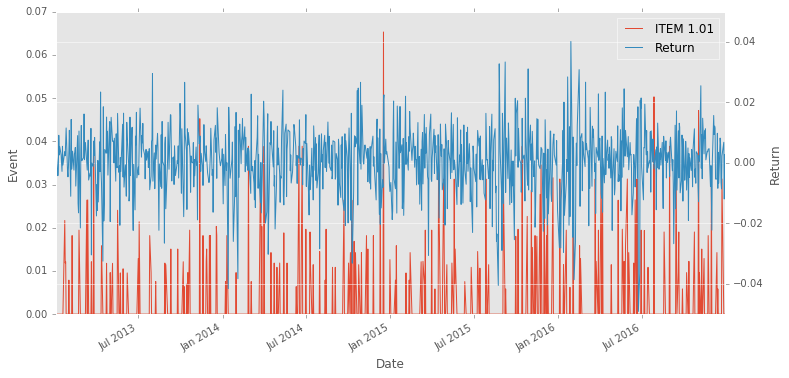

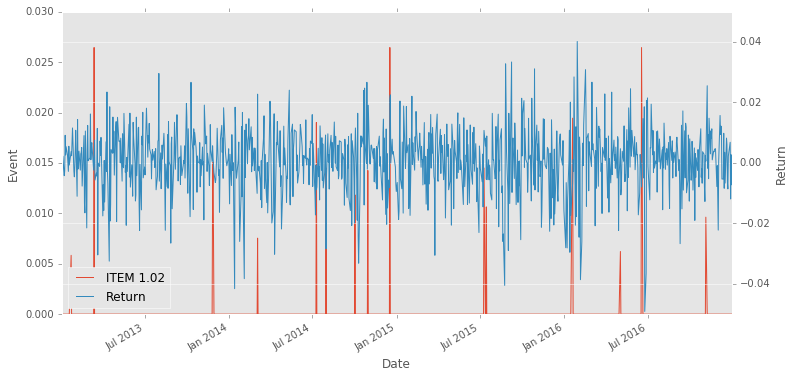

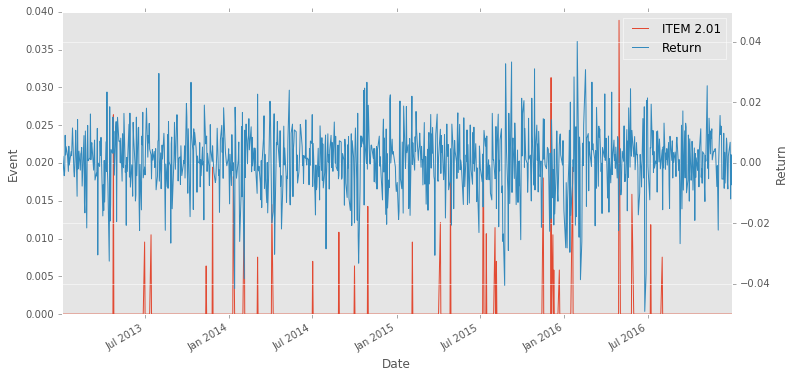

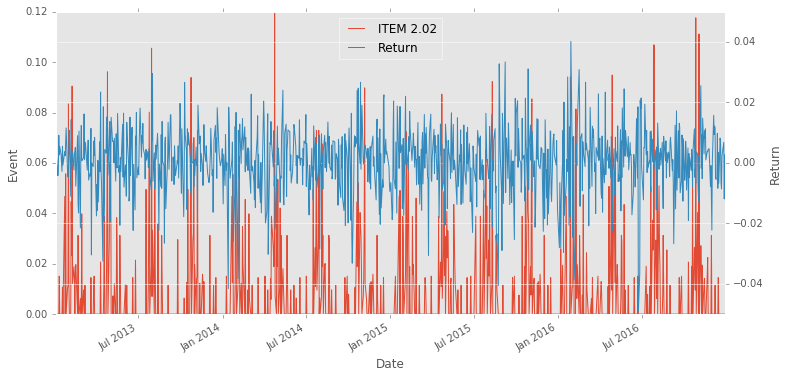

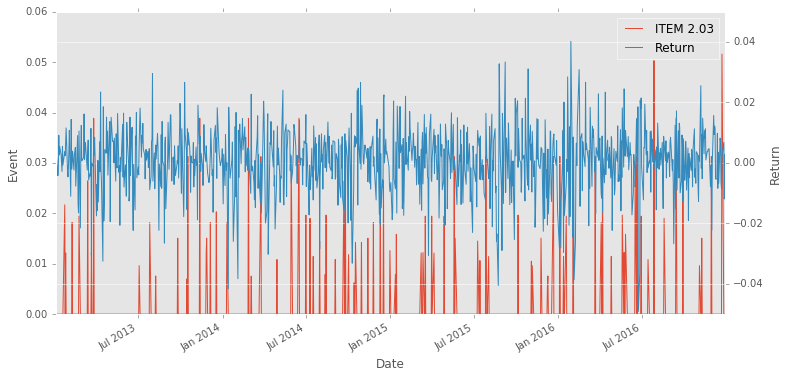

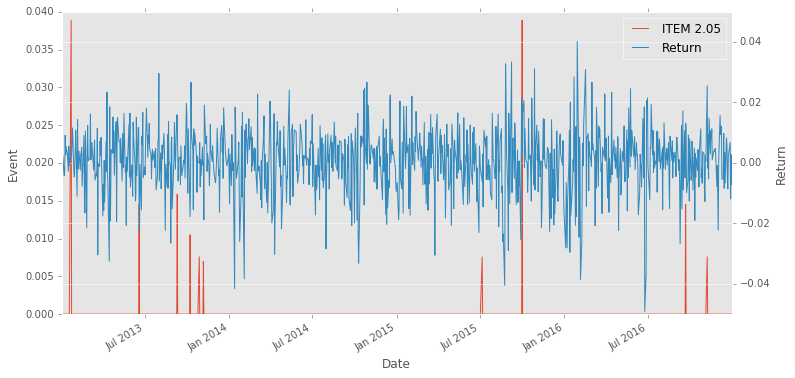

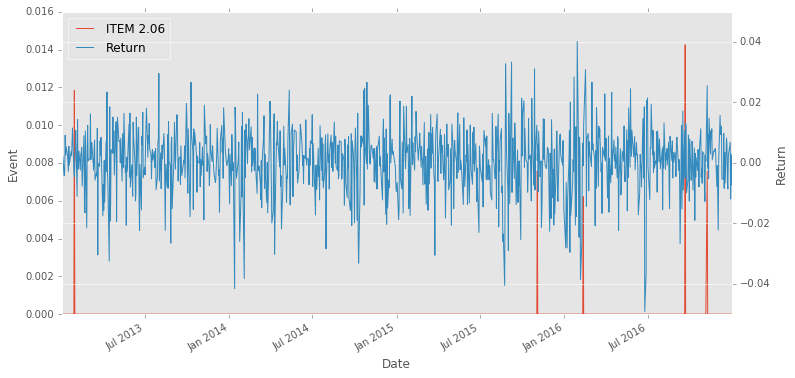

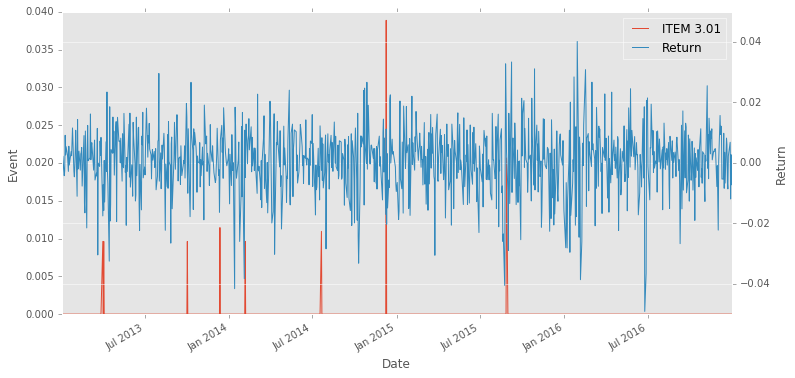

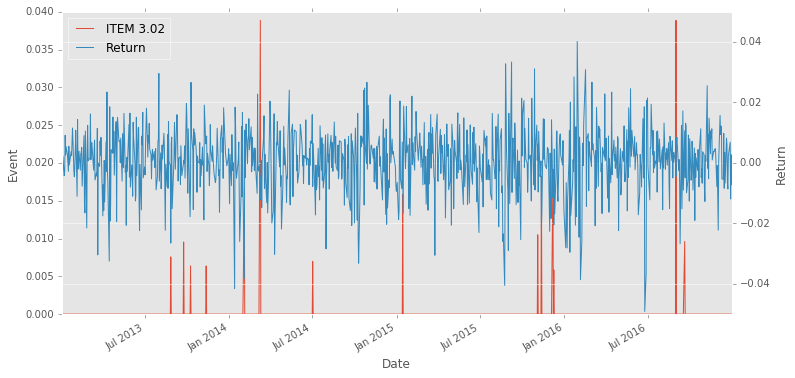

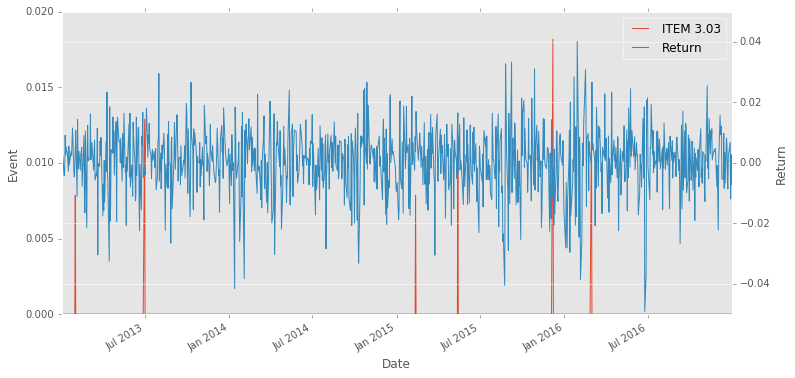

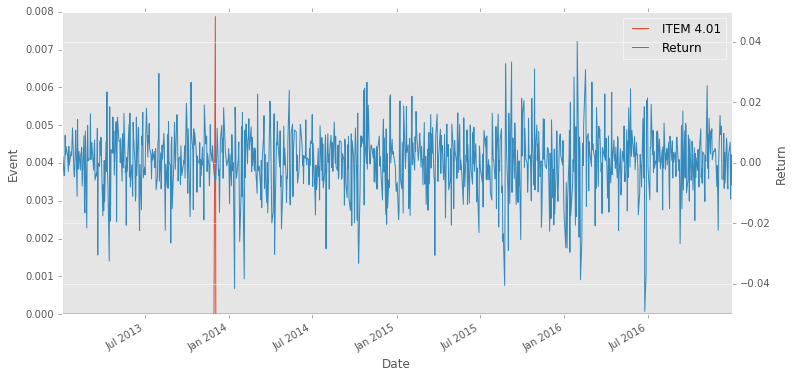

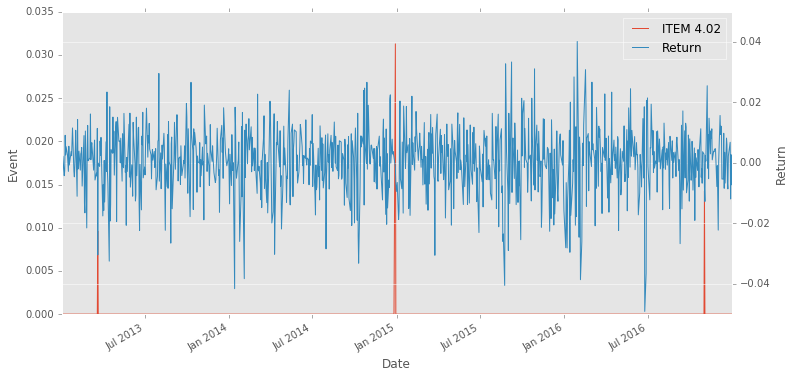

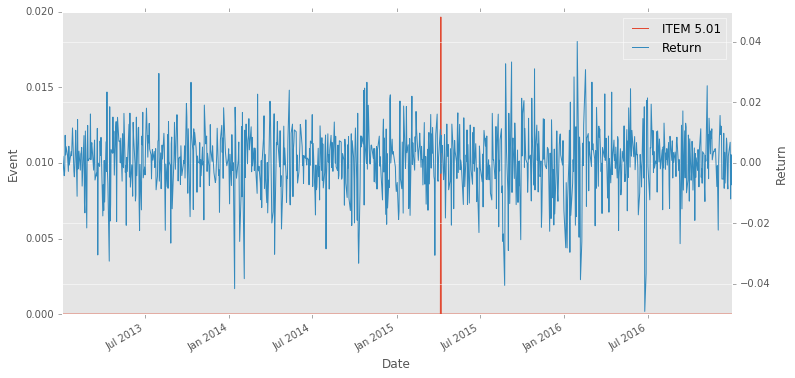

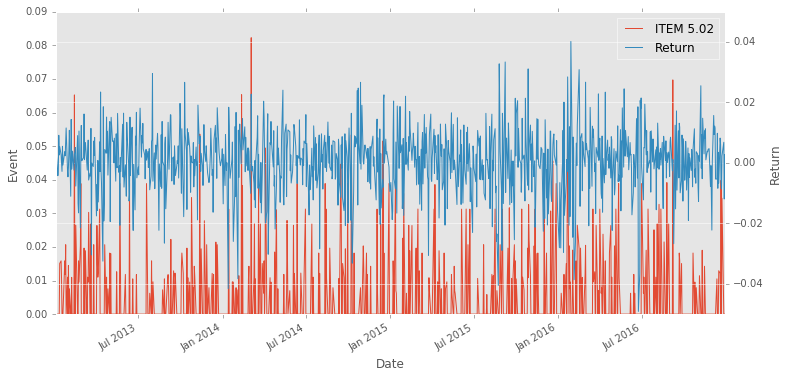

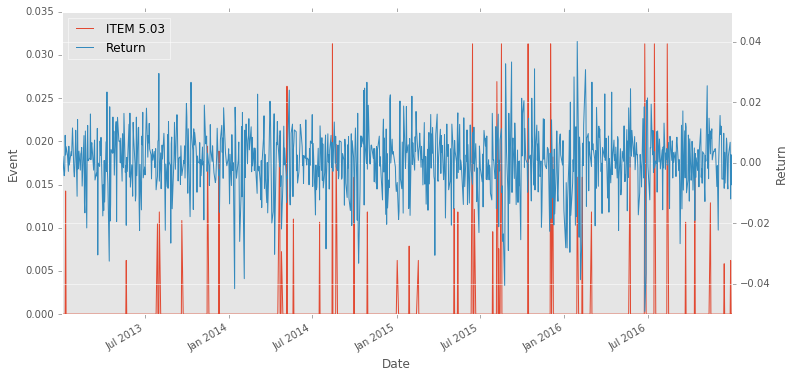

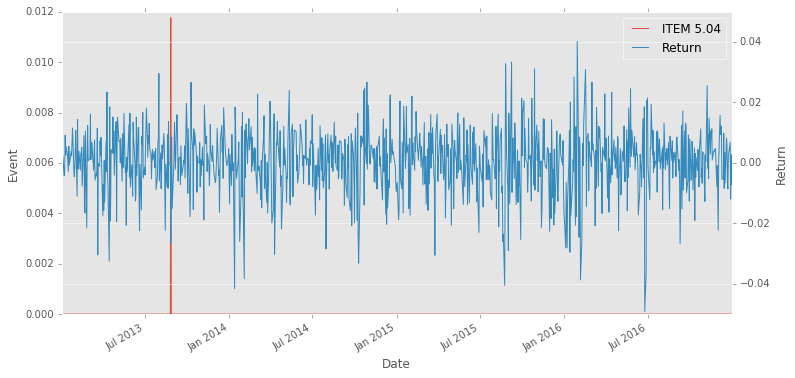

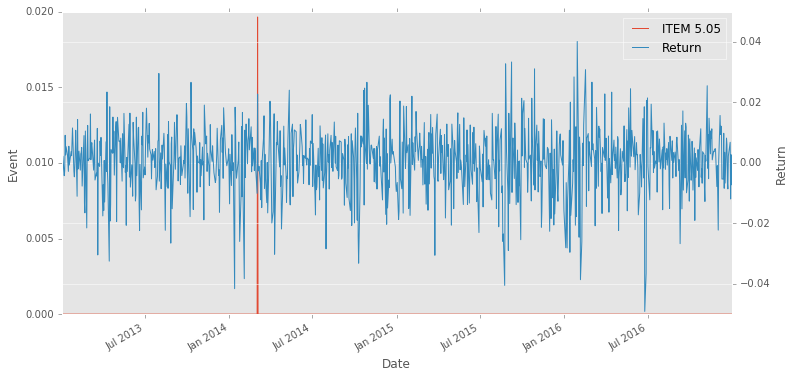

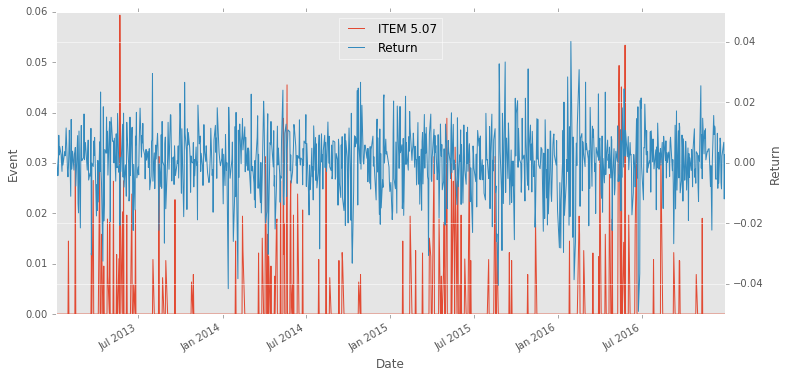

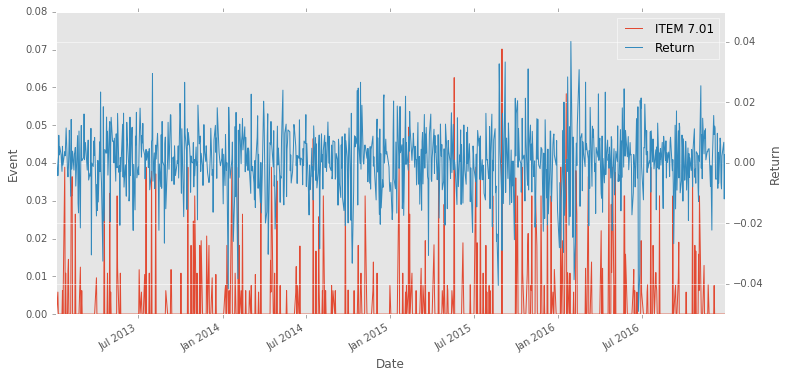

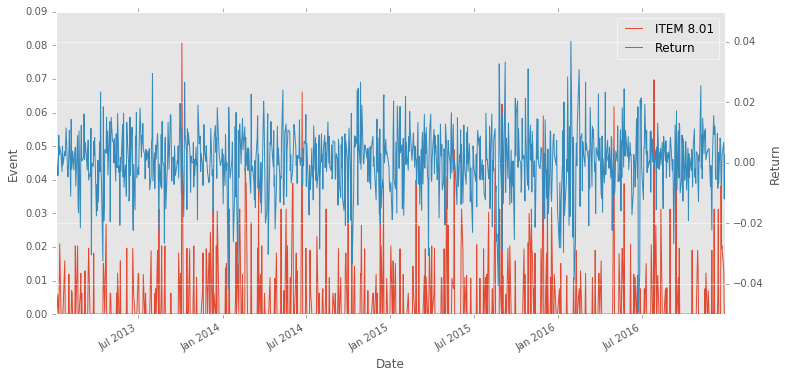

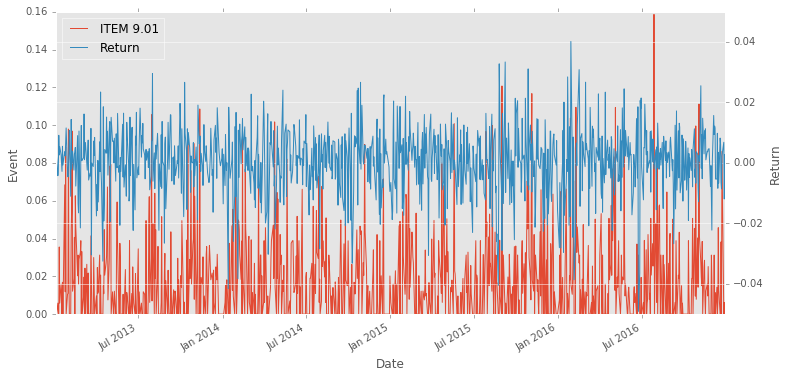

In [17]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('foo.pdf')

for item in keep_events:
    temp=pd.DataFrame({item:df_text.loc[:,item].copy()})
    temp["Return"]=df_return.loc[:,"Return"]
    
    plt.figure()
    
    ax = temp.plot(secondary_y=["Return"],figsize=(12, 6),mark_right=False)

    ax.set_ylabel('Event')
    ax.right_ax.set_ylabel('Return')
    
    pp.savefig()
    
pp.close()

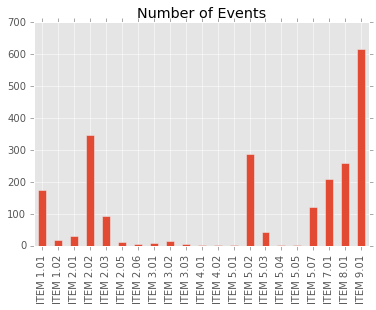

In [39]:
events_count=np.zeros(len(df_text.columns))
for i in range(0,len(df_text.columns)):
    events_count[i]=np.count_nonzero(df_text.iloc[:,i])

events_count=pd.DataFrame(events_count,index=df_text.columns)
events_count.plot.bar(legend=None)
plt.title("Number of Events")
plt.savefig("Events_count_info.png")

In [18]:
df_text_sum=df_text.sum()
df_text_sum

ITEM 1.01     3.207230
ITEM 1.02     0.240021
ITEM 2.01     0.440680
ITEM 2.02     9.861786
ITEM 2.03     1.799383
ITEM 2.05     0.162770
ITEM 2.06     0.047435
ITEM 3.01     0.120407
ITEM 3.02     0.207817
ITEM 3.03     0.070470
ITEM 4.01     0.007873
ITEM 4.02     0.055153
ITEM 5.01     0.019652
ITEM 5.02     5.538719
ITEM 5.03     0.719077
ITEM 5.04     0.011761
ITEM 5.05     0.019652
ITEM 5.07     2.274947
ITEM 7.01     3.690345
ITEM 8.01     4.568354
ITEM 9.01    18.831618
dtype: float64

## Model Assessment - GARCH(1,1)/+Text - 2016

In [15]:
# Model Setup
# Default Setup (AR_lags=[1],intercept=[True, True])
# Estimation window= 125 days 

window=1000
events=df_text.columns

In [16]:
events

Index(['ITEM 1.01', 'ITEM 1.02', 'ITEM 2.01', 'ITEM 2.02', 'ITEM 2.03',
       'ITEM 2.05', 'ITEM 2.06', 'ITEM 3.01', 'ITEM 3.02', 'ITEM 3.03',
       'ITEM 4.01', 'ITEM 4.02', 'ITEM 5.01', 'ITEM 5.02', 'ITEM 5.03',
       'ITEM 5.05', 'ITEM 5.07', 'ITEM 7.01', 'ITEM 8.01', 'ITEM 9.01'],
      dtype='object')

In [17]:
# Input
Return=df_return.iloc[:,1]

In [18]:
# Output 
Output=pd.DataFrame(columns=["var0","noise0","alpha","beta0","mu","gamma0","gamma1","phi","decay",
                             "fore_var","fore_return","LR_ratio"],
                   index=events)

Decay_Text=pd.DataFrame(columns=events)

output_path="GARCH/Text_Garch_2016_v2.xlsx" #With base initials 

In [ ]:
Text=df_text.loc[:,"ITEM 1.01"]
Garch=TA.Text_Garch(Return,Text)
Garch.Estimate(text=False)

BASE=pd.DataFrame(columns=["var0","noise0","alpha","beta0","mu","gamma0","gamma1","phi","decay",
                             "fore_var","fore_return","LR_ratio"],
                   index=["BASE"])

BASE.loc["BASE","var0"]=Garch.var0
BASE.loc["BASE","noise0"]=Garch.noise0
BASE.loc["BASE","alpha"]=Garch.params["alpha"]
BASE.loc["BASE","beta0"]=Garch.params["beta"][0]
BASE.loc["BASE","mu"]=Garch.params["mu"]
BASE.loc["BASE","gamma0"]=Garch.params["gamma"][0]
BASE.loc["BASE","gamma1"]=Garch.params["gamma"][1]
BASE.loc["BASE","phi"]=Garch.params["phi"]
BASE.loc["BASE","decay"]=Garch.params["decay"]
BASE.loc["BASE","fore_var"]=Garch.var
BASE.loc["BASE","fore_return"]=Garch.expectation
BASE.loc["BASE","LR_ratio"]=Garch.MLL

Ready
7
844.9916703
984.95368835
1146.0327506
1161.4382017
1291.72017085
1673.45668437
2060.15919099
2237.9511423
2284.2825233
2957.73662555
2974.08911248
3074.19145707
3091.5262112
3108.36444155
3110.03280534
3111.58297782
3111.71601284
3111.91998062
3112.41420159
3113.51112939
3115.73127893
3119.26089787
3125.23855424
3127.69068085
3128.77874309
3128.99498881
3129.16660473


In [ ]:
BASE_params=BASE.loc["BASE",["var0","noise0","alpha","beta0","mu","gamma0","gamma1"]]

In [ ]:
BASE

In [ ]:
initial_text=BASE_params.copy()
initial_text["phi"]=random.random()*0.1
initial_text["decay"]=random.random()*0.1
initial_text.as_matrix()

In [ ]:
'''
initial_text=[0.054945252004929182, 0.046104013218600762, 0.027075651062174692,
       0.027948875886597023, 0.00089476999847165617, 0.066648475370535407,
       0.034517085019726709, 0.05911455832982052, 0.012434616594218295]
'''
for i,item in enumerate(events):
    print(i,item)
    Text=df_text.sum(axis=1)
    Garch=TA.Text_Garch(Return,Text)
    Garch.Estimate(initial=initial_text.as_matrix())
    
    Output.loc[item,"var0"]=Garch.var0
    Output.loc[item,"noise0"]=Garch.noise0   
    Output.loc[item,"alpha"]=Garch.params["alpha"]
    Output.loc[item,"beta0"]=Garch.params["beta"][0]
    Output.loc[item,"mu"]=Garch.params["mu"]
    Output.loc[item,"gamma0"]=Garch.params["gamma"][0]
    Output.loc[item,"gamma1"]=Garch.params["gamma"][1]
    Output.loc[item,"phi"]=Garch.params["phi"]
    Output.loc[item,"decay"]=Garch.params["decay"]
    Output.loc[item,"fore_var"]=Garch.var
    Output.loc[item,"fore_return"]=Garch.expectation
    Output.loc[item,"LR_ratio"]=Garch.MLL
    
    #Decay_Text.loc[:,item]=Garch.decay_Text

In [21]:
Garch.decay_Text

Date
2015-12-31     0.000000e+00
2016-01-04     1.641838e-02
2016-01-05     1.017718e-01
2016-01-06     6.289526e-26
2016-01-07     1.568790e-01
2016-01-08     6.742601e-03
2016-01-11     6.324740e-02
2016-01-12     3.908706e-26
2016-01-13     2.483046e-02
2016-01-14     1.282539e-02
2016-01-15     7.926125e-27
2016-01-19     2.863506e-01
2016-01-20     2.483046e-02
2016-01-21     3.392395e-02
2016-01-22     7.993933e-02
2016-01-25     1.886824e-74
2016-01-26     5.976268e-02
2016-01-27     6.588273e-02
2016-01-28     2.250045e-01
2016-01-29     3.438365e-02
2016-02-01     2.276559e-02
2016-02-02     5.489781e-02
2016-02-03     1.418328e-01
2016-02-04     1.711495e-01
2016-02-05     1.057708e-25
2016-02-08     2.496530e-98
2016-02-09     2.957606e-01
2016-02-10     1.292459e-01
2016-02-11     7.759134e-02
2016-02-12     9.998453e-02
                  ...      
2016-11-17     1.521991e-26
2016-11-18     2.649759e-02
2016-11-21     3.438365e-02
2016-11-22     3.483577e-02
2016-11-23     

In [18]:
Output

,var0,noise0,alpha,beta0,mu,gamma0,gamma1,phi,decay,fore_var,fore_return,LR_ratio
ITEM 1.01,0.0548788,0.046104,0.00350374,0.0279183,-0.000106066,0.066621,0.0343118,0.00919043,0.0124346,9.47644e-05,0.0035794,667.87
ITEM 1.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM 2.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM 2.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM 2.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM 2.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM 2.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM 3.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM 3.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ITEM 4.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
Output=pd.concat([Output,BASE])

In [31]:
TA.save_xls([Output],output_path,["2016_1008days"])

In [32]:
def get_decayed_text(Text_param,Text):
    phi=Text_param.phi
    decay=Text_param.decay
    
    decay_Text=pd.Series(index=Text.index)
    for i,item in decay_Text.iteritems():
        #if i>Text.index[0]: # after first event
        weights= np.array(0.5**((i-Text.loc[:i].index).days/decay))
        decay_Text.loc[i]=Text.loc[:i].as_matrix().dot(weights)
        #else:
        #    decay_Text.loc[i]=0
    decay_Text.fillna(0)
    
    return(decay_Text)

In [33]:
Decay_text=pd.DataFrame(index=df_text.index,columns=df_text.columns)

for i,item in enumerate(df_text.columns):
    Text=df_text.loc[:,item]
    Text_param=Output.loc[item,["phi","decay"]]
    
    Decay_text.loc[:,item]=get_decayed_text(Text_param,Text)

In [34]:
TA.save_xls([Decay_text],"GARCH/GARCH_Decay_Text_2016_v2.xlsx",["Decay_text"])

AttributeError: 'str' object has no attribute 'to_excel'

In [ ]:
def result_comp(param,Return,Decay):
    alpha=param.alpha
    beta0=param.beta0
    mu=param.mu
    gamma0=param.gamma0
    gamma1=param.gamma1
    phi=param.phi
    noise0=param.noise0
    var0=param.var0 
    
    Comp=pd.DataFrame(index=Return.index,
                  columns=["Real Return","Model Return","Residual Return","Model Var"])
    
    Comp.loc[:,"Real Return"]=Return
    
    Comp.iloc[0,1]=0
    Comp.iloc[0,2]=noise0 
    Comp.iloc[0,3]=var0
    
    for j in range(1,len(Comp.index)):
        Comp.iloc[j,1]=alpha+beta0*Return[j-1]
        Comp.iloc[j,2]=(Comp.iloc[j,0]-Comp.iloc[j,1])
        Comp.iloc[j,3]=abs(mu+gamma0*Comp.iloc[j,2]**2+gamma1*Comp.iloc[j-1,3]**2+phi*Decay.iloc[j])
        
    return(Comp)


In [ ]:
Models_comp=[]
for item in Output.index:
    param=Output.loc[item,["alpha","beta0","mu","gamma0","gamma1","phi","noise0","var0"]]
    Decay=Decay_Text[item]
    comp=result_comp(param,Return,Decay)
    Models_comp.append(comp)


In [ ]:
TA.save_xls(Models_comp,"GARCH/GARCH_Models_comp_2016_v2.xlsx",Output.index)

## Model Assessment - GARCH(1,1)/+Text - one day rolling window

In [6]:
# Model Setup
# Default Setup (AR_lags=[1],intercept=[True, True])
# Rolling window= 125 days 

window=125

events=df_text.columns
periods=df_return.index[:window+2]
fore_periods=periods[window:]

In [7]:
# Input
Return=df_return.iloc[1:,1]

In [8]:
# Output 
LR_ratio=pd.DataFrame(columns=events,index=fore_periods)
alpha=pd.DataFrame(columns=events,index=fore_periods)
beta0=pd.DataFrame(columns=events,index=fore_periods)
mu=pd.DataFrame(columns=events,index=fore_periods)
gamma0=pd.DataFrame(columns=events,index=fore_periods)
gamma1=pd.DataFrame(columns=events,index=fore_periods)
decay=pd.DataFrame(columns=events,index=fore_periods)
phi=pd.DataFrame(columns=events,index=fore_periods)
fore_var=pd.DataFrame(columns=events,index=fore_periods)
fore_return=pd.DataFrame(columns=events,index=fore_periods)
fore_return["Realized Return"]=Return.loc[fore_periods]

# Output
output_names=["LR_ratio","fore_var","fore_return","alpha","beta0","mu","gamma0","gamma1","phi","decay"]
outputs=[LR_ratio,fore_var,fore_return,alpha,beta0,mu,gamma0,gamma1,phi,decay]
output_path="8K data/Text_Garch.xlsx"

In [8]:
Text=df_text.loc[:,"ITEM 1.01"]

for j,date in enumerate(periods[:-window]):
    start=periods[0+j]
    end=periods[window-1+j]
    fore_date=periods[window+j]

    print(start,end,fore_date)

    Garch=TA.Text_Garch(Return.loc[start:end],Text)

    Garch.Estimate(text=False)

    LR_ratio.loc[fore_date,"Base"]=Garch.MLL
    
    alpha.loc[fore_date,"Base"]=Garch.params["alpha"]
    beta0.loc[fore_date,"Base"]=Garch.params["beta"][0]
    mu.loc[fore_date,"Base"]=Garch.params["mu"]
    gamma0.loc[fore_date,"Base"]=Garch.params["gamma"][0]
    gamma1.loc[fore_date,"Base"]=Garch.params["gamma"][1]

    fore_var.loc[fore_date,"Base"]=Garch.var
    fore_return.loc[fore_date,"Base"]=Garch.expectation

2013-01-02 00:00:00 2013-07-01 00:00:00 2013-07-02 00:00:00
Ready
7
24.1816393726
153.056737972
153.49337963
153.92793101
172.353933149
173.202549848
181.397405931
281.716412721
306.167125641
308.137162189
326.066951041
327.86346005
342.624533639
343.077361796
349.795747413
362.498704383
362.728390107
378.596634926
381.868266742
383.33521702
383.509647437
383.791992732
2013-01-03 00:00:00 2013-07-02 00:00:00 2013-07-03 00:00:00
Ready
7
54.4820832957
195.393782743
267.544241758
267.692046005
269.453496694
269.842528861
271.147020273
275.569286888
288.574176674
297.763082731
364.175978309
382.581759335
383.579874929
386.737336506
387.418825987
388.096605872
388.205243725
388.37626926
388.522448377


In [9]:
for i,item in enumerate(events):
    print(i,item)
    Text=df_text.loc[:,item]
    
    for j,date in enumerate(periods[:-window]):
        start=periods[0+j]
        end=periods[window-1+j]
        fore_date=periods[window+j]
        
        print(start,end,fore_date)
        
        Garch=TA.Text_Garch(Return.loc[start:end],Text)
        
        Garch.Estimate()
        
        LR_ratio.loc[fore_date,item]=Garch.MLL
        alpha.loc[fore_date,item]=Garch.params["alpha"]
        beta0.loc[fore_date,item]=Garch.params["beta"][0]
        mu.loc[fore_date,item]=Garch.params["mu"]
        gamma0.loc[fore_date,item]=Garch.params["gamma"][0]
        gamma1.loc[fore_date,item]=Garch.params["gamma"][1]
        decay.loc[fore_date,item]=Garch.params["decay"]
        phi.loc[fore_date,item]=Garch.params["phi"]
        fore_var.loc[fore_date,item]=Garch.var
        fore_return.loc[fore_date,item]=Garch.expectation

0 ITEM 1.01
2013-01-02 00:00:00 2013-07-01 00:00:00 2013-07-02 00:00:00
Ready
9
54.1440652461
89.5486170941
89.8624916458
171.139756066
187.213627879
234.051663655
290.689408789
306.299195486
315.145041191
316.657395348
317.110760017
317.685702465
319.876185133
329.648159547
332.001899495
340.219671973
340.801540286
363.054423636
368.355302467
374.15644949
380.607778035
381.990156762
384.891368015
385.535556339
385.639827104
386.048798656
386.240705704
386.393398226
386.749117389
2013-01-03 00:00:00 2013-07-02 00:00:00 2013-07-03 00:00:00
Ready
9
40.7171717457
113.916491716
121.312733453
1 ITEM 1.02
2013-01-02 00:00:00 2013-07-01 00:00:00 2013-07-02 00:00:00
Ready
9
117.960159883
215.857546509
216.378125976
216.611777116
216.8377335
216.956262934
217.42858127
219.284632586
224.965197361
274.8048773
278.302349611
280.060689242
286.534555131
286.8775046
298.71752515
301.762020034
337.867253187
352.455821219
356.80976394
359.853083123
361.063948265
361.217239049
361.352650544
361.60800930

In [10]:
TA.save_xls(outputs,output_path,output_names)

In [12]:
comp_text=pd.DataFrame({"Raw_text":Text.loc["2013-01-03":"2013-07-02"],
                        "Decay_text":test.decay_Text})

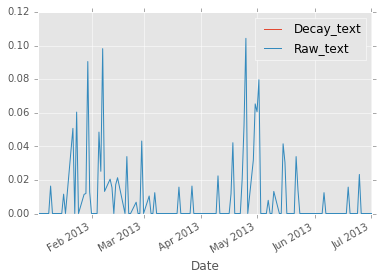

In [13]:
comp_text.plot()